In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data.csv')
df.head()

,Tmax,SysLoad,GasPrice,ElecPrice
FullDate,,,,
2010-09-01 00:00:00,15.8,1688.215,3.69,23.710
2010-09-01 01:00:00,15.8,1669.195,3.69,22.635
2010-09-01 02:00:00,15.8,1491.980,3.69,22.565
2010-09-01 03:00:00,15.8,1330.760,3.69,18.910
2010-09-01 04:00:00,15.8,1247.940,3.69,18.030


In [3]:
df.shape

(92016, 4)

In [4]:
#mark all missing values
df.replace('?', 'nan', inplace = True)

In [5]:
df.describe(include = 'all')

,Tmax,SysLoad,GasPrice,ElecPrice
count,92016.000000,92016.000000,92016.000000,92016.000000
mean,231.696688,797.623357,6.016163,65.798356
std,4562.128748,613.520156,2.608116,213.144084
min,9.900000,-1596.810100,0.000000,-924.820000
25%,17.300000,417.119800,3.936900,31.543750
50%,21.900000,856.467925,5.165600,48.715000
75%,27.600000,1221.293675,8.023300,76.495000
max,99999.900000,3264.166300,29.990000,14700.000000


In [6]:
df.isnull().sum()

Tmax         0
SysLoad      0
GasPrice     0
ElecPrice    0
dtype: int64

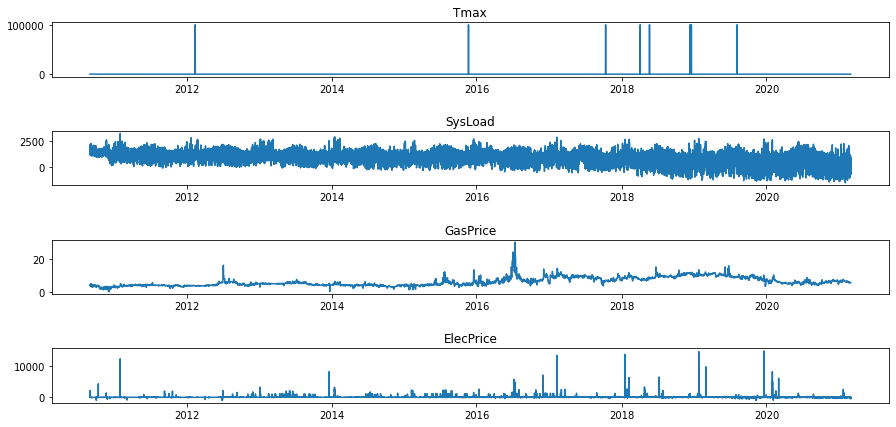

In [7]:
plt.figure(figsize = (15, 7))
for i in range(len(df.columns)):
    plt.subplot(len(df.columns), 1, i+1)
    name = df.columns[i]
    plt.plot(df[name])
    plt.title(name)
plt.subplots_adjust(hspace=1)
plt.show()

In [8]:
##Resampling the data points(Downsampling)
df_daily = df.resample('D').sum()

In [9]:
df_daily.head()

,Tmax,SysLoad,GasPrice,ElecPrice
FullDate,,,,
2010-09-01,379.2,41565.380,88.56,2751.700
2010-09-02,369.6,38898.990,88.56,570.810
2010-09-03,439.2,41665.760,106.80,504.975
2010-09-04,328.8,35638.085,81.36,502.275
2010-09-05,357.6,35611.410,106.80,500.555


In [10]:
df_daily.shape

(3834, 4)

Text(0, 0.5, 'ElecPrice')

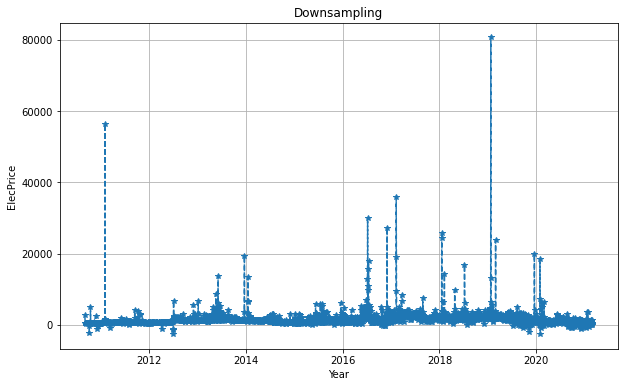

In [11]:
plt.figure(figsize=(10,6))
plt.plot(df_daily.index, df_daily.ElecPrice, '--', marker='+', )
plt.grid()
plt.xlabel('Year')
plt.ylabel('ElecPrice')

In [12]:
from statsmodels.tsa.stattools import adfuller

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [13]:
series = df_daily.loc[:, 'SysLoad'].values
result = adfuller(series, autolag='AIC')
print(f'p-value: {result[1]}')

p-value: 0.004253725504574117


In [14]:
series = df_daily.loc[:, 'ElecPrice'].values
result = adfuller(series, autolag='AIC')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'{key},{value}') 

Critial Values:
   1%, -3.432066157296446
Critial Values:
   5%, -2.8622983040036005
Critial Values:
   10%, -2.5671736550459663


#split the dataset into train and test
#The shape of test dataset will be (x-2757) where x is the total number of data points
#The train dataset will be the first 2757 days

In [15]:
train_df = df_daily[:2757]

In [16]:
train_df.shape

(2757, 4)

In [17]:
train_df.head()

,Tmax,SysLoad,GasPrice,ElecPrice
FullDate,,,,
2010-09-01,379.2,41565.380,88.56,2751.700
2010-09-02,369.6,38898.990,88.56,570.810
2010-09-03,439.2,41665.760,106.80,504.975
2010-09-04,328.8,35638.085,81.36,502.275
2010-09-05,357.6,35611.410,106.80,500.555


In [18]:
test_df = df_daily[2757:]

In [19]:
test_df.shape

(1077, 4)

In [20]:
test_df.head()

,Tmax,SysLoad,GasPrice,ElecPrice
FullDate,,,,
2018-03-20,540.0,7696.91130,201.5880,1833.00
2018-03-21,571.2,4658.05865,203.2560,1730.49
2018-03-22,722.4,19161.78525,203.2560,2260.55
2018-03-23,811.2,18090.43435,198.6456,2138.76
2018-03-24,832.8,3763.53865,180.2160,1721.70


#Prepare train and test dataset by renaming FullDate column and ElecPrice for univariate modelling

In [21]:
train_new_df = train_df.reset_index()
train_new_df = train_new_df.rename(columns={"FullDate": "ds", "ElecPrice": "y"})
train_new_df = train_new_df[['ds', 'y']]
train_new_df.head()

,ds,y
0,2010-09-01,2751.700
1,2010-09-02,570.810
2,2010-09-03,504.975
3,2010-09-04,502.275
4,2010-09-05,500.555


In [22]:
test_new_df = test_df.reset_index()
test_new_df = test_new_df.rename(columns={"FullDate": "ds", "ElecPrice": "y"})
test_new_df = test_new_df[['ds', 'y']]
test_new_df.head()

,ds,y
0,2018-03-20,1833.00
1,2018-03-21,1730.49
2,2018-03-22,2260.55
3,2018-03-23,2138.76
4,2018-03-24,1721.70


In [23]:
from fbprophet import Prophet
model = Prophet()
daily_seasonality=True
model.fit(train_new_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [24]:
pred = model.make_future_dataframe(periods=1077, freq='D') 
y_pred = model.predict(pred) 

In [25]:
y_pred.shape

(3834, 19)

In [26]:
y_pred.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2010-09-01,851.777631,-1336.646773,3470.764662,851.777631,851.777631,144.250503,144.250503,144.250503,159.308129,159.308129,159.308129,-15.057627,-15.057627,-15.057627,0.0,0.0,0.0,996.028134
1,2010-09-02,851.727173,-1222.389229,3551.737400,851.727173,851.727173,224.453910,224.453910,224.453910,257.036327,257.036327,257.036327,-32.582418,-32.582418,-32.582418,0.0,0.0,0.0,1076.181083
2,2010-09-03,851.676716,-1445.845744,3233.273895,851.676716,851.676716,-0.584510,-0.584510,-0.584510,50.257478,50.257478,50.257478,-50.841988,-50.841988,-50.841988,0.0,0.0,0.0,851.092206
3,2010-09-04,851.626258,-1809.348462,3053.210211,851.626258,851.626258,-340.872526,-340.872526,-340.872526,-271.372061,-271.372061,-271.372061,-69.500465,-69.500465,-69.500465,0.0,0.0,0.0,510.753732
4,2010-09-05,851.575800,-1845.502188,2754.020155,851.575800,851.575800,-430.884955,-430.884955,-430.884955,-342.634443,-342.634443,-342.634443,-88.250512,-88.250512,-88.250512,0.0,0.0,0.0,420.690845


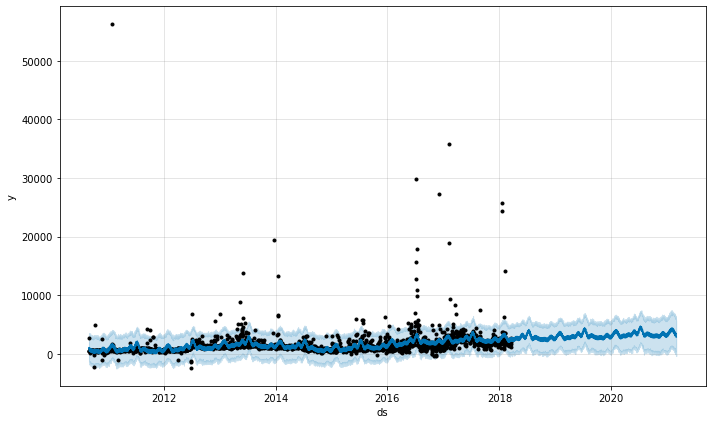

In [27]:
model.plot(y_pred)
plt.show()

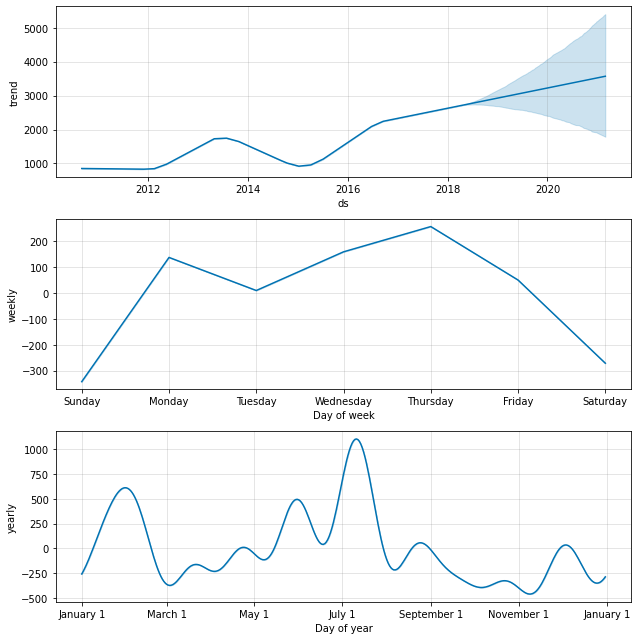

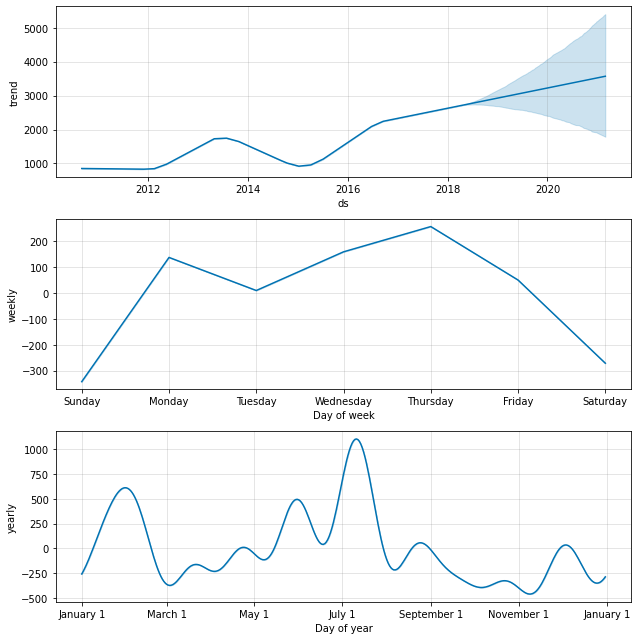

In [28]:
model.plot_components(y_pred)

In [29]:
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [30]:
mape(test_new_df['y'], y_pred['yhat'][2757:])

549.4751413716547

In [31]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test_new_df['y'], y_pred['yhat'][2757:])
rmse = round(np.sqrt(mse), 2)
rmse

3218.16

In [32]:
multi_df = df_daily.reset_index().rename(columns={"FullDate": "ds", "ElecPrice": "y", 'SysLoad': 'add1', 'Tmax': 'add2', 'GasPrice': 'add3'})

In [33]:
multi_df.head()

,ds,add2,add1,add3,y
0,2010-09-01,379.2,41565.380,88.56,2751.700
1,2010-09-02,369.6,38898.990,88.56,570.810
2,2010-09-03,439.2,41665.760,106.80,504.975
3,2010-09-04,328.8,35638.085,81.36,502.275
4,2010-09-05,357.6,35611.410,106.80,500.555


In [34]:
multi_df.shape

(3834, 5)

In [35]:
train_df = multi_df[:2757]

In [36]:
test_df = multi_df[2757:]

In [37]:
train_df.shape

(2757, 5)

In [38]:
test_df.shape

(1077, 5)

In [39]:
model2 = Prophet()
model2.add_regressor('add1')
model2.add_regressor('add2')
model2.add_regressor('add3')
model2.fit(train_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [40]:
pred2 = model2.make_future_dataframe(periods=1077, freq='D') 
pred2['add1'] = multi_df['add1'].values
pred2['add2'] = multi_df['add2'].values
pred2['add3'] = multi_df['add3'].values
y_pred2 = model2.predict(pred2) 

In [41]:
y_pred2.shape

(3834, 31)

In [42]:
y_pred2.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,add1,add1_lower,add1_upper,add2,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2010-09-01,999.344125,-710.634939,3729.704763,999.344125,999.344125,1036.684496,1036.684496,1036.684496,0.246552,...,42.497418,42.497418,42.497418,-4.148520,-4.148520,-4.148520,0.0,0.0,0.0,1517.026982
1,2010-09-02,999.900105,-882.982512,3697.635858,999.900105,999.900105,887.762012,887.762012,887.762012,0.247400,...,145.822951,145.822951,145.822951,-7.069370,-7.069370,-7.069370,0.0,0.0,0.0,1469.066011
2,2010-09-03,1000.456085,-429.296341,3870.704193,1000.456085,1000.456085,1042.290892,1042.290892,1042.290892,0.241251,...,-44.133439,-44.133439,-44.133439,-10.049485,-10.049485,-10.049485,0.0,0.0,0.0,1699.128738
3,2010-09-04,1001.012066,-1270.632335,3352.297979,1001.012066,1001.012066,705.634840,705.634840,705.634840,0.251004,...,-117.735502,-117.735502,-117.735502,-12.818541,-12.818541,-12.818541,0.0,0.0,0.0,912.988678
4,2010-09-05,1001.568046,-1033.911023,3369.074252,1001.568046,1001.568046,704.144995,704.144995,704.144995,0.248460,...,-69.893610,-69.893610,-69.893610,-15.133453,-15.133453,-15.133453,0.0,0.0,0.0,1331.257873


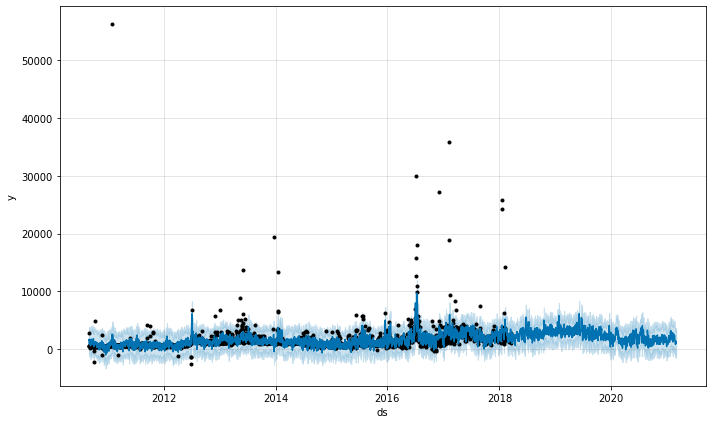

In [43]:
model2.plot(y_pred2)
plt.show()

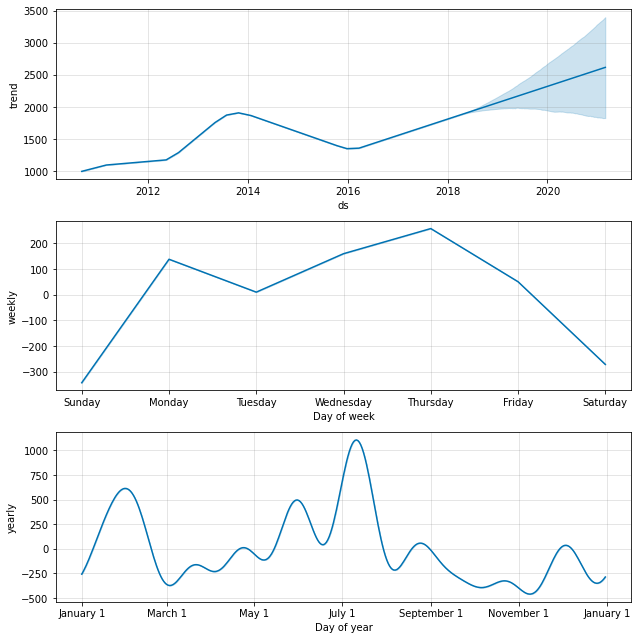

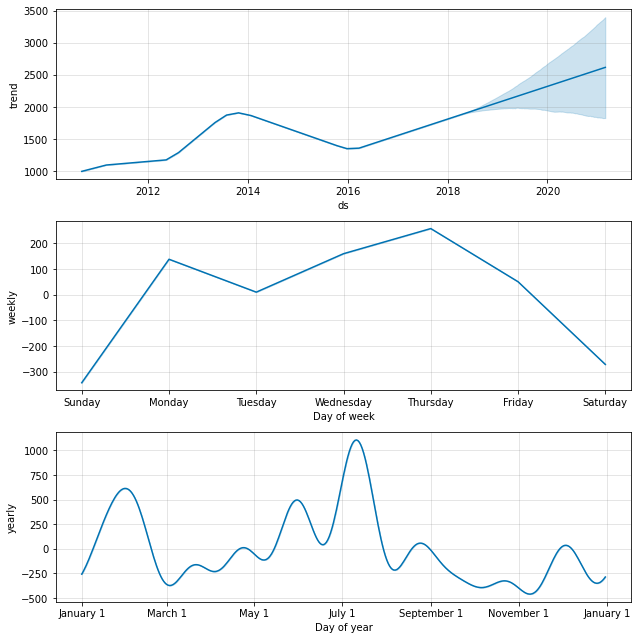

In [44]:
model.plot_components(y_pred2)

In [45]:
mape(test_df['y'], y_pred2['yhat'][2757:])

233.74494702819595

In [46]:
mse2 = mean_squared_error(test_df['y'], y_pred2['yhat'][2757:])
rmse2 = round(np.sqrt(mse2), 2)
rmse2

2709.65